# Script to generate routes between fed locations

Code inspired from https://ipython-books.github.io/147-creating-a-route-planner-for-a-road-network/

Data(.shp file) from https://mapcruzin.com/free-delhi-country-city-place-gis-shapefiles.htm

In [1]:
import io
import os
import zipfile
import networkx as nx
import numpy as np
import pandas as pd
import json

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Geocoding')
sys.path.insert(2, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Range')

In [3]:
def unzip_file(name):
  zipped_file = name
  zip_ref = zipfile.ZipFile(zipped_file, 'r')
  zip_ref.extractall('.')
  zip_ref.close()

In [4]:
unzip_file('delhi_highway.zip')

In [5]:
import gdal
g = nx.read_shp('delhi_highway.shp')

In [6]:
# Requires a lot of space, graph too big

# nx.draw(g)
# plt.show()

In [7]:
# Graph might not be connected, this function will yield the largest connected subgraph.
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

sgs = list(connected_component_subgraphs(g.to_undirected())) # sgs is a list of subgraphs

i = np.argmax([len(sg) for sg in sgs]) # i holds the location of the largest connected subgraph
# print(i)
sg = sgs[i] # sg is the subgraph of interest

# print(len(sg)) # number of nodes in this subgraph

In [39]:
from GeocodeAddress import geocoding
print("Enter source: ")
address = input()
pos0 = geocoding(address)
print("Enter destination: ")
address = input()
pos1 = geocoding(address)

Enter source: 
Mayur Vihar, Delhi, India
Enter destination: 
Chanakyapuri, Delhi, India


In [40]:
print("Source entered: ", pos0)
print("Destination entered: ", pos1)

Source entered:  (28.6131071, 77.2957221)
Destination entered:  (28.5946775, 77.1885212)


In [41]:
def get_path(n0, n1): # n0 and n1 are tuples(containing the latitude and longitude) of the 2 locations
# returns points linking the 2 given locations
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [42]:
radius = 6372.8
def calcDist(lat0, lon0, lat1, lon1):
    # calculates and returns the Great-Circle Distance using the cosine formula****(in km)****
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    
    return radius*c

In [43]:
# leverages the calcDist function to calculate the length between given 2 points
def get_path_length(path):
    return np.sum(calcDist(path[1:, 1], path[1:, 0], path[:-1, 1], path[:-1, 0])) # pass the lat and lon of the 2 points

Get Charging Stations from csv

In [44]:
df = pd.read_csv('ModifiedStations.csv')
df['location'] = list(zip(df.LATITUDE, df.LONGITUDE))

In [45]:
stations = []
for station in df.location:
    stations.append(station)
    
stations = np.array(stations) # Convert list to numpy array
    
stations = stations[:, ::-1]  # Flip the tuple from (lat, lon) to (lon, lat)
# print(stations)

station_set = set()
for val in stations:
    val = val.tolist()
    val = tuple(val)
    station_set.add(val)
    
# print(station_set)  # Set of locations of the charging stations stored as tuples.(lon, lat)

In [46]:
def first_quadrant(src, dest):
    # have to find stations such that their lon >= lon of src && <= lon of dest and their lat >= lat of src and <= lat of dest
    lat_bound, lon_bound = pos1[0], pos1[1]
    possible_stations = []
    for val in station_set:
        if(val[1] <= lat_bound and val[0] <= lon_bound and val[1] >= src[0] and val[0] >= src[1]):
            possible_stations.append(val)
            
    return possible_stations

In [47]:
def second_quadrant(src, dest):
    lat_bound, lon_bound = pos1[0], pos1[1]
    possible_stations = []
    for val in station_set:
        if(val[1] <= lat_bound and val[0] >= lon_bound and val[1] >= src[0] and val[0] <= src[1]):
            possible_stations.append(val)
            
    return possible_stations

In [48]:
def third_quadrant(src, dest):
    lat_bound, lon_bound = pos1[0], pos1[1]
    possible_stations = []
    for val in station_set:
        if(val[1] >= lat_bound and val[0] >= lon_bound and val[1] <= src[0] and val[0] <= src[1]):
            possible_stations.append(val)
            
    return possible_stations

In [49]:
def fourth_quadrant(src, dest):
    lat_bound, lon_bound = pos1[0], pos1[1]
    possible_stations = []
    for val in station_set:
        if(val[1] >= lat_bound and val[0] <= lon_bound and val[1] <= src[0] and val[0] >= src[1]):
            possible_stations.append(val)
            
    return possible_stations

In [50]:
# pos0 src, pos1 dest
possible_stations = []

# print(pos0, pos1)

if(pos1[1] > pos0[1] and pos1[0] > pos0[0]):
    # first quadrant
    possible_stations = first_quadrant(pos0, pos1)
    print("first")
    
elif(pos1[1] < pos0[1] and pos1[0] > pos0[0]):
    # second quadrant
    possible_stations = second_quadrant(pos0, pos1)
    print("second")
    
elif(pos1[1] < pos0[1] and pos1[0] < pos0[0]):
    # third quadrant
    possible_stations = third_quadrant(pos0, pos1)
    print("third")
    
elif(pos1[1] > pos0[1] and pos1[0] < pos0[0]):
    # fourth quadrant
    possible_stations = fourth_quadrant(pos0, pos1)
    print("fourth")
    
print("Number of stations inside the bounding box: ", len(possible_stations))

third
Number of stations inside the bounding box:  5


Build graph

In [51]:
# Update the graph edges by assigning the weights of the edges, the actual distance between the 2 nodes in km.

for n0, n1 in sg.edges:
    path = get_path(n0, n1) # will return numpy array of points, path is a list of lats and lons each returned in a list format, hence a list of lists.
    dist = get_path_length(path)
    sg.edges[n0, n1]['distance'] = dist # update step

In [52]:
# Our requested positions might not be on the graph, find the locations on the graph closest to them

# print(sg.edges)   # list of nested tuples.
# print(sg.nodes)   # list of nodes.
# print(len(sg))    # Number of nodes in this subgraph.

# get all the nodes of the constructed graph into an array and find the point closest to target point.
nodes = np.array(sg.nodes)
# print("Nodes array: ", nodes) # list of latitudes and longitudes(Total 278 datapoints)(latitudes and longitudes are stored as list and not tuple)
#  Nodes are also stored as (lon, lat).

In [53]:
def getClosestPointIndex(loc):
    loc_i = np.argmin(np.sum((nodes[:, ::-1] - loc)**2, axis=1))
    return loc_i

In [54]:
# Get the closest nodes in the graph. source_i and destination_i return index of the points closest to requested points in the nodes array
source_i = getClosestPointIndex(pos0)
destination_i = getClosestPointIndex(pos1)


# # Get the points closest to the 2 charging stations that are available on our shapefile.
# source_station_i = np.argmin(np.sum((nodes - closestStationToSource)**2, axis=1))
# dest_station_i = np.argmin(np.sum((nodes - closestStationToDest)**2, axis=1))


# print("Source, Closest charging station from source, Closest charging station from destination and Destination indices: ", source_i, source_station_i, dest_station_i, destination_i)
print("Source: ", nodes[source_i])
print("Destination: ", nodes[destination_i])

Source:  [77.2989824 28.5905085]
Destination:  [77.1750181 28.5804843]


In [55]:
if(len(possible_stations) > 0):
    station_dict = {}
    for station in possible_stations:
        station_i = np.argmin(np.sum((nodes - station)**2, axis=1))
        station_dict[station] = station_i
#     print("Station locations along with their indices :\n", station_dict)

In [56]:
from RangeCalculation import getRange

rem_charge = float(input("Enter the remaining battery level: "))
can_travel, deets = getRange(rem_charge)

print(f'Vehicle: {deets[0]}, Range on full-charge: {deets[1]}')
range_on_full_charge = deets[1]
print(f"The car can travel {can_travel} km based on the current charge of {rem_charge}%")

Enter the remaining battery level: 30
Please select the Model: 

1	Hyundai Kona Electric SUV

2	Tata Nexon EV

3	MG ZS EV

4	Tata Tigor EV

5	Mahindra E2O P2 Automatic

6	Bajaj Chetak

7	Revolt RV400

8	Ather 450X

9	TVS iQube Electric

10	PURE EV Pluto 

11	PURE EV Pluto 7G

12	Joy-eBike Monster

13	Avon E bike

14	Avon E scoot

15	Hero Electric Optima LA

16	Hero Electric Dash

17	Okinawa Praise

18	Revolt RV300

Enter Here: 2
Vehicle: Tata Nexon EV, Range on full-charge: 312
The car can travel 93.6 km based on the current charge of 30.0%


In [57]:
# get the shortest path length from source to all the possible stations and then refine the list of possible stations
# down to only those that can be reached based on the current charge

refined_possible_stations = []
if(len(possible_stations) > 0):
    for val, index in station_dict.items():
#         print(val, index)
        dist_to_station = nx.astar_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[index]),
                                weight = 'distance')
        if(dist_to_station < can_travel):
            refined_possible_stations.append(val)
            
    if(len(refined_possible_stations) > 0):
#         print("Possible stations that can be visited based on current charge(in (longitude, latitude) form): ", refined_possible_stations)
        print("Number of possible stations that can be visited based on current charge: ", len(refined_possible_stations))

Number of possible stations that can be visited based on current charge:  5


In [58]:
def getDistanceToDestination():
    dist = nx.astar_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[destination_i]),
                                weight = 'distance')
    print(f'The distance from the source to destination is {round(dist, 3)}km')
    return dist

In [59]:
def helper_StationClosestToSource():
    sourceDistToStation = 1e10
    closestStationToSource = []
    for val in stations:
        dist = calcDist(val[1], val[0], pos0[0], pos0[1])      # User entered values are (lat, lon) all others are (lon, lat)
        if dist < sourceDistToStation:
            closestStationToSource = val
            sourceDistToStation = dist
    print("Charging Station closest to source point entered: ", closestStationToSource)
    print("Distance of the closest charging station from source(in km): ", sourceDistToStation)
    station_i = np.argmin(np.sum((nodes - closestStationToSource)**2, axis=1))
    
    length_path1 = nx.astar_path_length(sg, 
                source = tuple(nodes[source_i]), 
                target = tuple(nodes[station_i]),
                weight = 'distance')
    length_path2 = nx.astar_path_length(sg, 
                source = tuple(nodes[station_i]), 
                target = tuple(nodes[destination_i]),
                weight = 'distance')
    
    print(f'The vehicle will have to cover a distance of {length_path1+length_path2}km in total.')
    print("Station closest to source point: ", nodes[station_i])
    
    return station_i

In [60]:
def getStationClosestToSource():
    # the old method of finding the station closest to source
    # Get charging station closest to the source
    
    # pos0 is the user-entered source

    dist = getDistanceToDestination()
    if(can_travel > dist):
        refuel = input("Your vehicle has enough charge to make it to the destination. Stop for a recharge anyway ?(YES/NO)")
        if(str.lower(refuel) == "yes"):
            station_i = helper_StationClosestToSource()
            
        elif(str.lower(refuel) == "no"):
            # route the user straight to the destination
            station_i = -1
            
    else:
        refuel = "yes"
        print("The vehicle will need to make a stop for recharging on the way to charging station. Finding the optimal route...")
        station_i = helper_StationClosestToSource()
        
    return station_i, refuel

In [61]:
if(len(refined_possible_stations) == 0):
    # no station close enough hence have to greedily look for the closest station for a recharge
    # i.e. no station inside the bounding box
    station_i, refuel = getStationClosestToSource()
    
elif(len(refined_possible_stations) > 0):
    # refined_possible_stations is the list of all stations the user can get to on remaining charge
    
    # maybe there is no need for a recharge, this will be in the case the dist from source to destination is lesser
    # than the remaining range, if so ask the user for a recharge anyway.

    dist = getDistanceToDestination()
    if(can_travel > dist):
        # they can get to the destination without a recharge, ask anyways
        refuel = input("Your vehicle has enough charge to make it to the destination. Stop for a recharge anyway ?(YES/NO)")
        if(str.lower(refuel) == "yes"):
            min_dist = 1e10
            for st in refined_possible_stations:
                st_i = station_dict[st] 
                dist1 = nx.astar_path_length(sg, 
                                        source = tuple(nodes[source_i]), 
                                        target = tuple(nodes[st_i]),
                                        weight = 'distance')
                dist2 = nx.astar_path_length(sg,
                                        source = tuple(nodes[st_i]),
                                        target = tuple(nodes[destination_i]),
                                        weight = 'distance')
                if(dist1+dist2 < min_dist):
                    station_i = st_i
                    min_dist = dist1+dist2
                    station_dist = dist1
                    destination_dist = dist2
#                 print("Distance: ", min_dist)
            
            # having calculated the choice of the station which minimises the total distance that will be covered
            # prompt the user again to reconsider their choice of going for a recharge if the "detour" is above
            # a certain threshold.
            
            length_path1 = nx.astar_path_length(sg, 
                            source = tuple(nodes[source_i]), 
                            target = tuple(nodes[station_i]),
                            weight = 'distance')
            length_path2 = nx.astar_path_length(sg, 
                            source = tuple(nodes[station_i]), 
                            target = tuple(nodes[destination_i]),
                            weight = 'distance')
            
            threshold = 1 # in km
            if(length_path1+length_path2-dist > threshold and can_travel > length_path1): # make the user re-consider the decision to go for recharging based on detour distance.
                print("The total distance that will have to be covered if you choose to go for a recharge is: ", length_path1+length_path2)
                print(f'Hence the vehicle will have to cover an extra {round((length_path1+length_path2-dist), 3)}km due to this detour')
                refuel = input("Do you still want to recharge your vehicle on the way to the destination ?(YES/NO)")
            
                if(str.lower(refuel) == "no"):
                    station_i = -1
                    
            if(str.lower(refuel) == "yes"):
                print(f'We will have to cover the least possible distance if we go through the charging station close to {nodes[station_i]} which is {round(station_dist, 2)}km away from the source and {round(destination_dist, 2)}km away from the destination.')
        
        
        elif(str.lower(refuel) == "no"):
            station_i = -1
            
    else:
        print("The vehicle will need to make a stop for recharging on the way to the destination. Finding the optimal route...")
        # a recharge is needed, so out of the possible stations get the one which has lowest total path length to the destination.
        min_dist = 1e10
        for st in refined_possible_stations:
            st_i = station_dict[st] 
            dist1 = nx.astar_path_length(sg, 
                                    source = tuple(nodes[source_i]), 
                                    target = tuple(nodes[st_i]),
                                    weight = 'distance')
            dist2 = nx.astar_path_length(sg,
                                    source = tuple(nodes[st_i]),
                                    target = tuple(nodes[destination_i]),
                                    weight = 'distance')
            if(dist1+dist2 < min_dist):
                station_i = st_i
                min_dist = dist1+dist2
                station_dist = dist1
                destination_dist = dist2
        
        # check if the nearest charging station is out-of-range:
        if(station_dist > can_travel):
            print('''The vehicle will not be able to make it to the nearest charging station on current charge levels. You might consider installing a backup battery pack or charging the current battery enough to get to the nearest charging station.''')
            
            # calculate charge needed to get to the nearest charging station.
            charge_needed = (station_dist/range_on_full_charge)*100
            
            print(f'''If you wish to charge the current battery, charge it till {round(charge_needed, 2)}% to get to the nearest charging station at {nodes[station_i]}.''')
            
            print("After the battery is charged to the minimal level, enter the battery details again.")
            
        else:
            refuel = "yes"
            print(f'We will have to cover the least possible distance if we go through the charging station close to {nodes[station_i]} which is {round(station_dist, 2)}km away from the source and {round(destination_dist, 2)}km away from the destination.')

The distance from the source to destination is 19.001km
Your vehicle has enough charge to make it to the destination. Stop for a recharge anyway ?(YES/NO)yes
We will have to cover the least possible distance if we go through the charging station close to [77.2084716 28.5707595] which is 15.08km away from the source and 3.92km away from the destination.


Utility function to build a continuous path from an array of nodes.

In [62]:
def get_full_path(path):
    """Return the positions along a path. Appends the points in the correct order to be able to build a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [63]:
# # dist1 and dist3 are the distances from source to station in the 2 cases, get the minimum of the 2
# station_dist = min(dist1, dist3)
# if(can_travel > min(dist1+dist2, dist3+dist4)+1):
#     # buffer of 1 km
#     print("The vehicle has enough fuel to make it to the destination.")
#     refuel = input("Would you like to stop for refuelling anyway ?(Type YES or NO)")
#     # if refuel YES, plot the shortest source->station->destination route.
#     if(str.lower(refuel) == "yes"):
#         if(dist3+dist4 < dist1+dist2):
#             station_i = dest_station_i
#         else:
#             station_i = source_station_i
#         print("We will have to cover lesser distance if go to the charging station close to: ", nodes[station_i])
#     elif(str.lower(refuel) == "no"):
#         station_i = -1
    
    
# else:
#     print("The vehicle will need to make a stop for recharging on the way to the destination.")
#     # check if the vehicle can make it to the further of the 2 stations, if yes choose the shortest source->station->destination route.
#     # buffer of 1 km
#     if(can_travel > max(dist1, dist3)+1):
#         if(dist3+dist4 < dist1+dist2):
#             station_i = dest_station_i
#         else:
#             station_i = source_station_i
#         refuel = "yes"
#         print("We will have to cover lesser distance if go to the charging station close to: ", nodes[station_i])
        
#     else:
#         if(can_travel < min(dist1, dist3)):
#             print('''The vehicle won't be able to make it to any nearby charging station based on the current charge,
#                   you might want to consider instaliing the backup battery or charging the current battery(from any
#                   reliable power source nearby) enough to get to the nearest charging station.''')
            
#             nearest_station_dist = min(dist1, dist3)
#             charge_needed = (nearest_station_dist/range_on_full_charge)*100
            
#             print(f'''If you choose to charge your current battery you would have to charge it to {charge_needed}% to get
#                   to the nearest charging station which is {nearest_station_dist}km away''')
#         # have to go to the nearest station even if it means travelling a longer distance overall to the destination.
#         elif(can_travel > min(dist1, dist3)):
#             if(dist1 < dist3):
#                 station_i = source_station_i
#             else:
#                 station_i = dest_station_i
#             print("We will have to go to the station close to: ", nodes[station_i])

There are 2 cases to consider :
1. The vehicle goes for refuelling(by the user's choice(if the car has enough charge) or necessarily(lack of enough charge to take it to the destination directly))
2. The user chooses not to refuel and go to the destination directly instead.

Instantiate the map(this step is common for both the cases)

In [64]:
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
m = smopy.Map(pos0, pos1, z=15, margin=0.95)
# tried to play around with the smopy source code for better zoom levels
# not of much help..
# keep trying optimal levels for "maxtiles" and "get_allowed_zoom"

Box x:  29 Box y: 6
Box x:  15 Box y: 3
Box x:  8 Box y: 2
Box x:  4 Box y: 2
Lowered zoom level to keep map size reasonable. (z = 12)
Box x:  4 Box y: 2


Case 1(refuelling) has been considered below

Upon choosing the charging station we want to visit, build the route accordingly.

In [66]:
if(str.lower(refuel) == "yes"):

    # Compute the shortest path from source to the charging station closest to source point.
    path1 = nx.astar_path(
        sg,
        source=tuple(nodes[source_i]),
        target=tuple(nodes[station_i]),
        weight='distance')  # Computes the shortest path (weighted by distance).
    
    length_path1 = nx.astar_path_length(sg, 
                            source = tuple(nodes[source_i]), 
                            target = tuple(nodes[station_i]),
                            weight = 'distance')

    # Compute the shortest path from charging station closest to source point to destination.
    path2 = nx.astar_path(
        sg,
        source=tuple(nodes[station_i]),
        target=tuple(nodes[destination_i]),
        weight='distance')
    
    length_path2 = nx.astar_path_length(sg, 
                            source = tuple(nodes[station_i]), 
                            target = tuple(nodes[destination_i]),
                            weight = 'distance')

    # path = path1+path2 # is the final path from source->nearest charging station->destination
    # print("Path 1: ", path1)
    # print("Path 2: ", path2)
    # print("Path: ", path)
    # The path variable now contains the list of edges that form the shortest path between requested positions
    # print(len(path))

In [67]:
if(str.lower(refuel) == "yes"):
    # Get the co-ordinates of the approximate source, charging station and destination:
    print("Source: ", nodes[source_i])
    print("Station: ", nodes[station_i])
    print("Destination: ", nodes[destination_i])

Source:  [77.2989824 28.5905085]
Station:  [77.2084716 28.5707595]
Destination:  [77.1750181 28.5804843]


In [68]:
if(str.lower(refuel) == "yes"):
    if source_i != station_i:
        linepath = get_full_path(path1)
        a, b = m.to_pixels(linepath[:, 1], linepath[:, 0])

    else:
        print("There's a charging station right where you are !")
        
    if station_i != destination_i:
        linepath = get_full_path(path2)
        x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])
        
    else:
        print("There's a charging station right next to your destination point!")

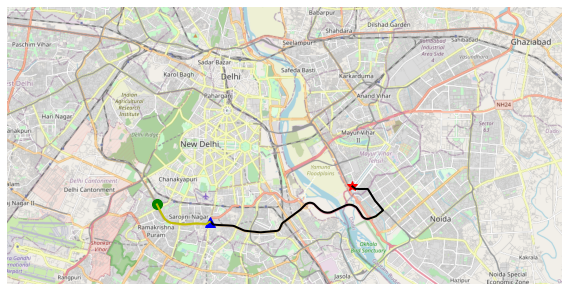

In [69]:
if(str.lower(refuel) == "yes"):
    
    ax = m.show_mpl(figsize=(8, 8))

    # Mark our positions.(Source->Station->Destination : RBG)
    # Source will be marked with '*' in red.
    if source_i == station_i:
        ax.plot(x[0], y[0], 'or', ms=10, marker='*')
        ax.plot(x[-1], y[-1], 'og', ms=10)
        
    elif destination_i == station_i:
        ax.plot(a[0], b[0], 'or', ms=10, marker='*')
        ax.plot(a[-1], b[-1], 'og', ms=10)    
        
    else:
        ax.plot(a[0], b[0], 'or', ms=10, marker='*')
        ax.plot(x[0], y[0], 'ob', ms=10, marker='^')
        ax.plot(x[-1], y[-1], 'og', ms=10)       
    
    

    # Mark the 2 paths, first from source to closest charging station and then from there on to the destination.
    if source_i != station_i:
        ax.plot(a, b, '-k', lw=2) # Source to station is marked with black.
    if station_i != destination_i:
        ax.plot(x, y, '-y', lw=2) # Station to destination is marked with yellow.

    # NOTE: If the black and yellow lines overlap, yellow will be seen.

Case 2(the user chooses not to refuel their vehicle and go to the destination directly instead) has been considered below

In [70]:
if(str.lower(refuel) == "no"):
    # Compute the shortest path from source to the destination.
    path = nx.astar_path(
        sg,
        source=tuple(nodes[source_i]),
        target=tuple(nodes[destination_i]),
        weight='distance')  # Computes the shortest path (weighted by distance).

In [71]:
if(str.lower(refuel) == "no"):
    print("Source: ", nodes[source_i])
    print("Destination: ", nodes[destination_i])

In [72]:
if(str.lower(refuel) == "no"):
    linepath = get_full_path(path)
    x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

In [73]:
if(str.lower(refuel) == "no"):
    ax = m.show_mpl(figsize=(8, 8))
    ax.plot(x[0], y[0], 'or', ms=10, marker='*')
    ax.plot(x[-1], y[-1], 'og', ms=10)
    ax.plot(x, y, '-k', lw=2)

Check if there's a charging station close to the destination, so that the vehicle can be taken there instead and 
charged up, while the user can carry out whatever activity at their destination point.(THIS IS YET TO BE WORKED ON, THE BELOW CELL IS JUST A FRAMEWORK OF AN IDEA, NOT TO BE INCORPORATED INTO THE SCRIPT YET)

In [39]:
# # Check for a charging station within {threshold}km radius of the destination.
# threshold = 1 # distance in km
# if(dist4 <= threshold):
#     # ask if the user wants to take their car to the station
#     print("Do you want to take the car to a charging station nearby ?(YES or NO)")
#     flag = input()
#     if(str.lower(flag) == "no"):
#         pass
#     else:
#         # plot the route from destination to station
#         path_w = nx.shortest_path(
#         sg,
#         source=tuple(nodes[destination_i]),
#         target=tuple(nodes[dest_station_i]),
#         weight='distance')  # Computes the shortest path (weighted by distance).
        
#         linepath_w = get_full_path(path_w)
#         w1, w2 = m.to_pixels(linepath[:, 1], linepath[:, 0])
        
#         ax_w = m.show_mpl(figsize=(8, 8))
#         ax_w.plot(w1[0], w2[0], 'og', ms=10)
#         ax_w.plot(w1[-1], w2[-1], 'om', ms=10, marker=',')
#         ax_w.plot(w1, w2, '-c', lw=2)

In [ ]:
# # Check if there's a charging station closer to the destination than the source, possible optimization.

# # Incorporate the range information later, for now, assume the car can get to the destination without needing a recharge.

# destDistToStation = 1e10
# closestStationToDest = []

# # find the closest station to the destination.
# for val in stations:
#     dist = calcDist(val[1], val[0], pos1[0], pos1[1])
#     if dist < destDistToStation:
#         closestStationToDest = val
#         destDistToStation = dist
        
# print("Charging Station closest to destination point entered: ", closestStationToDest)
# print("Distance of the closest charging station from destination(in km): ", destDistToStation)